Like many others, Titanic is the first kaggle completition I attended. In this notebook you will find how I use model stacking, a common ensemble technique on Kaggle, to submit my very first result on the LB! 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
fullset = [train, test] 
train.columns
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')


The following EDA and feature engineering are inspired  by Sina: https://www.kaggle.com/sinakhorami/titanic-best-working-classifier


In [3]:
# Feature Engineering

# Let's tackle each feature one by one
# PassengerId, leave it there?
# Survived: our target
# Pclass
train.Pclass.isnull().value_counts() # there are no null values
# train.Sex.value_counts()
# train.Sex.isnull().value_counts()
# test.Sex.isnull().value_counts()
for dataset in fullset:
    # Sex: let's convert Sex into binary variable. Non-binary shouldn't exist back then right?
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)
    


In [4]:
# for age we need imputation
for dataset in fullset:
    age_mean = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_imp = np.random.randint(age_mean - age_std,age_mean + age_std, size = age_null_count)
    
    dataset['Age'][np.isnan(dataset['Age'])] = age_imp
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Categorical_Age'] = pd.qcut(dataset['Age'],4)
    
print(train[['Survived','Categorical_Age']].groupby(['Categorical_Age'],as_index = False).mean())
for dataset in fullset:
    dataset.loc[dataset['Age']<=21.0,'Age'] = 0
    dataset.loc[(dataset['Age']>21.0)&(dataset['Age']<=28.0),'Age'] = 1
    dataset.loc[(dataset['Age']>28.0)&(dataset['Age']<=38.0),'Age'] = 2
    dataset.loc[dataset['Age']>38.0,'Age'] = 4
    dataset['Age'] = dataset['Age'].astype(int)
    
print(dataset['Age'].value_counts())

  Categorical_Age  Survived
0  (-0.001, 21.0]  0.413386
1    (21.0, 29.0]  0.366197
2    (29.0, 38.0]  0.386364
3    (38.0, 80.0]  0.362745
1    106
4    104
2    104
0    104
Name: Age, dtype: int64


In [5]:
# Create feature FamilySize from sibsp and parch
for dataset in fullset:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [6]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [7]:
# Fare

test['Fare'].isnull().value_counts() # only one missing value in testing set
# we can just use mean imputation
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())
for dataset in fullset:
    dataset['Categorical_Fare'] = pd.qcut(dataset['Fare'],4)
    
print(train[['Survived','Categorical_Fare']].groupby('Categorical_Fare',as_index = False).mean())
print(train['Categorical_Fare'].value_counts())
print(test['Categorical_Fare'].value_counts())

for dataset in fullset:
    dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
    dataset.loc[(dataset['Fare']<=14.454) & (dataset['Fare']>7.91),'Fare'] = 1
    dataset.loc[(dataset['Fare']<=31.0) & (dataset['Fare']>14.454),'Fare'] = 2
    dataset.loc[dataset['Fare']>31.0,'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

print(train['Fare'].value_counts())
    

  Categorical_Fare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081
(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: Categorical_Fare, dtype: int64
(-0.001, 7.896]    114
(14.454, 31.5]     105
(31.5, 512.329]    103
(7.896, 14.454]     96
Name: Categorical_Fare, dtype: int64
2    229
0    223
3    222
1    217
Name: Fare, dtype: int64


In [8]:
# Cabin Number
train.Cabin.isnull().value_counts()
# perhaps no need for using this feature??

True     687
False    204
Name: Cabin, dtype: int64

In [9]:
# Embarked
train.Embarked.isnull().value_counts() # 2 missing values
test.Embarked.isnull().value_counts()  # no missing values
# impute using median
train['Embarked'] = train['Embarked'].fillna('S')
# train.Embarked.value_counts() # 2 missing values


# converting
embarked_mapping = {'C':0,'Q':1,'S':2}
for dataset in fullset:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping).astype(int)

print(train[['Survived','Embarked']].groupby(['Embarked'],as_index = False).mean())

   Embarked  Survived
0         0  0.553571
1         1  0.389610
2         2  0.339009


In [10]:
# credit to Sina 
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in fullset:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex         0    1
Title             
Capt        1    0
Col         2    0
Countess    0    1
Don         1    0
Dr          6    1
Jonkheer    1    0
Lady        0    1
Major       2    0
Master     40    0
Miss        0  182
Mlle        0    2
Mme         0    1
Mr        517    0
Mrs         0  125
Ms          0    1
Rev         6    0
Sir         1    0


In [11]:
# Here let's be creative and get some manual feature different from the original
for dataset in fullset:
    dataset['Title'] = dataset['Title'].replace(['Capt','Major','Col'],'Military')
    dataset['Title'] = dataset['Title'].replace(['Countess','Don','Dona','Jonkheer','Lady','Master','Sir'],'Nobility')
    dataset['Title'] = dataset['Title'].replace(['Dr','Rev'],'Educated')
    #common sense replacement
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
print(train[['Survived','Title']].groupby(['Title'],as_index = False).mean())
print(test['Title'].value_counts())

      Title  Survived
0  Educated  0.230769
1  Military  0.400000
2      Miss  0.702703
3        Mr  0.156673
4       Mrs  0.793651
5  Nobility  0.577778
Mr          240
Miss         79
Mrs          72
Nobility     22
Educated      3
Military      2
Name: Title, dtype: int64


In [12]:
title_mapping = {'Educated': 0, 'Military':1,'Miss':2,'Mr':3,'Mrs':4,'Nobility':5}
for dataset in fullset:
    dataset['Title'] = dataset['Title'].map(title_mapping).astype(int)
    
print(train['Title'].value_counts())

3    517
2    185
4    126
5     45
0     13
1      5
Name: Title, dtype: int64


In [13]:
# preparing training and testing dataset
train_X = train.drop(['Survived','Name','Ticket','Categorical_Age','Categorical_Fare',
                     'PassengerId','SibSp','Parch','Cabin'],axis = 1)
# test_X = test.drop(['Name','Ticket'],axis = 1)
train_y = train['Survived']
test_X = test.drop(['Name','Ticket','Categorical_Age','Categorical_Fare',
                     'PassengerId','SibSp','Parch','Cabin'],axis = 1)
# retain only numpy array
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values



Investigate different classifiers:
* Logistic Regression
* SVM
* Decision Tree
* Random Forest
* AdaBoost
* Gradient Boosting Classifier
* Multilayer perceptron
* Gaussian Naive Bayes
* Linear Discriminant Analysis
* K-Nearest Neighbor




In [14]:
# import model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
SEED = 0
sss = StratifiedShuffleSplit(n_splits = 10,test_size= 0.1,random_state = SEED)
sss.split(train_X,train_y)
classifiers = [SVC(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
               LogisticRegression(),
               GaussianNB(),
               KNeighborsClassifier(),
               LinearDiscriminantAnalysis(),
               MLPClassifier(),
               DecisionTreeClassifier()]

acc_table = {} # a dictionary store the prediction
for train_index, test_index in sss.split(train_X,train_y):
    train_X_cv, test_X_cv = train_X[train_index],train_X[test_index]
    train_y_cv, test_y_cv = train_y[train_index],train_y[test_index]
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(train_X_cv,train_y_cv)
        predict_y = clf.predict(test_X_cv)
        acc = accuracy_score(test_y_cv,predict_y)
        if name in acc_table:
            acc_table[name] += acc
        else:
            acc_table[name] = acc

for name in acc_table:
    acc_table[name] = acc_table[name]/len(classifiers)
print(acc_table)

{'SVC': 0.8288888888888888, 'RandomForestClassifier': 0.8111111111111111, 'AdaBoostClassifier': 0.8288888888888888, 'GradientBoostingClassifier': 0.821111111111111, 'LogisticRegression': 0.8111111111111111, 'GaussianNB': 0.7766666666666666, 'KNeighborsClassifier': 0.7988888888888888, 'LinearDiscriminantAnalysis': 0.8044444444444444, 'MLPClassifier': 0.7966666666666666, 'DecisionTreeClassifier': 0.8055555555555556}


In [15]:
# print()
# acc_df = pd.DataFrame(acc_table.items(),columns = ['Classifier','Accuracy'])

acc_df = pd.DataFrame(list(acc_table.items()),columns = ['Classifier','Accuracy'])
# acc_df.index.name = 'Classifier'
# acc_df.reset_index()
acc_df = acc_df.sort_values('Accuracy',ascending = 0)
# acc_df

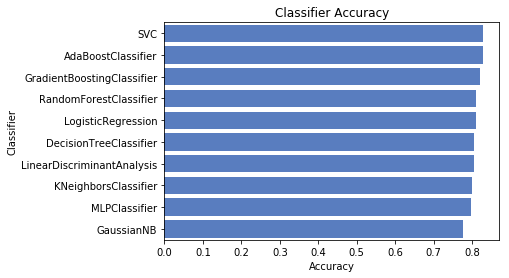

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=acc_df, color="b")

Here, we can use the top five classifiers as our first stacking layer.
Or using all of them and see how things go?
We can repeat the fit and predict process but this time around we wrap them into pipeline for simplification.


In [17]:
# from sklearn.model_selection import KFold
# SEED = 0
# kf = KFold(n_splits=5,random_state=SEED)
# kf.get_n_splits(train_X)
# # train_idx, test_idx = kf.split(train_X,train_y)
# type(kf)
# for i, (trainindex, testindex) in enumerate(kf.split(train_X)): 
#     print("%s %s" % (trainindex, testindex))

In [18]:
NFOLD = 10
sss = StratifiedShuffleSplit(n_splits = NFOLD,test_size= 0.1,random_state = SEED)
class SklearnHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    def train(self, train_X, train_y):
        self.clf.fit(train_X, train_y)
    def predict(self, x):
        return self.clf.predict(x)
    def fit(self,x,y):
        return self.clf.fit(x,y)
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLD, ntest))

    for i, (train_index, test_index) in enumerate(sss.split(x_train,y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [19]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'C' : 0.025
    }
logreg_params = {'max_iter' : 100}
mlp_params = {'verbose' : 0}
dt_params = {'min_samples_split' : 2}

svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
rf = SklearnHelper(clf = RandomForestClassifier, seed=SEED,params=rf_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
logreg = SklearnHelper(clf=LogisticRegression, seed=SEED, params=logreg_params)
mlp = SklearnHelper(clf=MLPClassifier, seed=SEED, params=mlp_params)
dt = SklearnHelper(clf=DecisionTreeClassifier, seed=SEED, params=dt_params)

In [20]:
x_train = train_X
y_train = train_y
x_test = test_X

ntrain = x_train.shape[0]
ntest = x_test.shape[0]
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
logreg_oof_train, logreg_oof_test = get_oof(logreg, x_train, y_train, x_test) # logreg
mlp_oof_train, mlp_oof_test = get_oof(mlp, x_train, y_train, x_test) # mlp
dt_oof_train, dt_oof_test = get_oof(dt, x_train, y_train, x_test) # mlp
print("Training is complete")

Training is complete


In [21]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
      'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
      'DecisionTrees': dt_oof_train.ravel(),
      'MLP': mlp_oof_train.ravel(),
      'LogReg':logreg_oof_train.ravel(),
      'SVC':svc_oof_train.ravel()
                                       })
base_predictions_train.head()

py.init_notebook_mode(connected=True)
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [22]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, gb_oof_train, dt_oof_train,mlp_oof_train,logreg_oof_train,
                          svc_oof_train), axis=1)
x_test = np.concatenate((rf_oof_test, ada_oof_test, gb_oof_test, dt_oof_test,mlp_oof_test,mlp_oof_test,
                         svc_oof_test), axis=1)

In [23]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [24]:
SubmissionCL = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': predictions })
SubmissionCL.to_csv("SubmissionCL.csv", index=False)
